# DM-42228 :  Illustrate SN code as a pipeline:

Setup:

* `lsst_distrib` **w2024_32** on RSP
* `ts_wep`  on **tickets/DM-42228** 

* corner sensors (lsstCam in focus) : DM-41957_lsstCam_sweep 
* FAM science rafts for lsstCam : DM-41957_lsstCam_sweep 
* R22 for lsstComCam  : DM-41679_lsstComCam 




# 1 a) lsstCam sweep data:  run from postISR to show behavior for legacy data (no variance)

In [2]:
import lsst.daf.butler as dafButler
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')

butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

In [3]:
#registry.queryCollections()

In [7]:
postIsrCollection = 'run_739388' # no variance 

Run interactively: single detector,  donut detection, passing to calcZernikesTask:

In [4]:
detector = 34
instrument = 'LSSTCam'
visit_extra = 5028081800962
visit_intra = 5028081800960
# construct a dataId for zernikes and donut catalog:
# switch exposure to visit
data_id_extra = {"detector": detector, 
           "instrument": instrument, 
           "visit": visit_extra,
           "exposure":visit_extra
          }

data_id_intra = {"detector": detector, 
           "instrument": instrument, 
           "visit": visit_intra,
           "exposure": visit_intra
          }

In [5]:
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections=["LSSTCam/calib/unbounded",],
)


In [8]:
exposure_extra = butler.get('postISRCCD', 
                              dataId=data_id_extra, 
                              collections=[postIsrCollection]
                            )
exposure_intra = butler.get('postISRCCD', 
                                  dataId=data_id_intra, 
                                  collections=[postIsrCollection]
                                )

FAM science sensor -  detect, cutout, calcZernikes: 

In [9]:
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask,
GenerateDonutDirectDetectTaskConfig
)


In [10]:
config = GenerateDonutDirectDetectTaskConfig()
detectTask = GenerateDonutDirectDetectTask(config=config)

In [11]:
output_extra = detectTask.run(exposure_extra, camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 24 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 24 of 24 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 16/24 references


In [43]:
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTask,
    CutOutDonutsScienceSensorTaskConfig,
)
config = CutOutDonutsScienceSensorTaskConfig()

In [45]:
config.maxRecenterDistance = 35

In [46]:
cutoutTask = CutOutDonutsScienceSensorTask(config=config)
cutoutResults = cutoutTask.run([exposure_intra, exposure_extra],
                  [output_extra.donutCatalog, output_extra.donutCatalog],
                  camera)



In [47]:
list(cutoutResults.donutStampsExtra.metadata)

['RA_DEG',
 'DEC_DEG',
 'DET_NAME',
 'CAM_NAME',
 'VISIT',
 'DFC_TYPE',
 'DFC_DIST',
 'MAG',
 'CENT_X0',
 'CENT_Y0',
 'CENT_X',
 'CENT_Y',
 'CENT_DX',
 'CENT_DY',
 'CENT_DR',
 'BLEND_CX',
 'BLEND_CY',
 'X0',
 'Y0',
 'SN',
 'SIGNAL_MEAN',
 'SIGNAL_SUM',
 'NPX_MASK',
 'BKGD_STDEV',
 'SQRT_MEAN_VAR',
 'BKGD_VAR',
 'BACKGROUND_IMAGE_MEAN',
 'NOISE_VAR_BKGD',
 'NOISE_VAR_DONUT',
 'EFFECTIVE',
 'ENTROPY',
 'PEAK_HEIGHT']

Ok, the above metadata already shows that given that there is no variance plane, we're using a backup method for estimation of SN. 

Now given the donut stamps have SN and entropy in the metadata, we can run Zernike estimation, and selection in the task. Try turning it on and off...

In [14]:
from lsst.ts.wep.task.calcZernikesTask import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
)

In [50]:
config = CalcZernikesTaskConfig()


In [25]:
config

lsst.ts.wep.task.calcZernikesTask.CalcZernikesTaskConfig(saveLogOutput=True, estimateZernikes={'instConfigFile': None, 'maxNollIndex': 22, 'startWithIntrinsic': True, 'returnWfDev': False, 'return4Up': True, 'usePairs': True, 'saveHistory': False, 'opticalModel': 'offAxis', 'maxIter': 30, 'compSequence': [4, 4, 6, 6, 13, 13, 13, 13, 22, 22, 22, 22], 'compGain': 0.6, 'centerTol': 1e-09, 'centerBinary': True, 'convergeTol': 1e-09, 'maskKwargs': {}, 'requiresPairs': True, 'modelPupilKernelSize': 2.0}, combineZernikes={'sigmaClipKwargs': {}, 'stdMin': 0.005, 'maxZernClip': 3}, donutStampSelector={'selectWithEntropy': False, 'selectWithSignalToNoise': False, 'useCustomSnLimit': False, 'minSignalToNoise': 600.0, 'maxEntropy': 3.5}, connections={'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg', 'donutsExtraQuality': 'donutsExtraQuality', 'donutsIntraQuality': 'donutsIntraQuality

We can set `config.donutStampSelector` to `selectWithEntropy`  , `selectWithSignalToNoise` . If either is true, then SN selection uses the SN limits from the policy file, and the entropy selection uses built-in limits. If we want to modify these limits, we set `useCustomSnLimit`, and can modify `minSignalToNoise` and `maxEntropy` . First, the default pass, which doesn't do any selection:

In [51]:
calcTask = CalcZernikesTask(config=config, name="Default: no selection")


In [52]:
taskOut = calcTask.run(cutoutResults.donutStampsExtra, cutoutResults.donutStampsIntra)

INFO:lsst.Default: no selection.donutStampSelector:Selected 16/16 donut stamps
INFO:lsst.Default: no selection.donutStampSelector:Selected 16/16 donut stamps
INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 14 pairs out of 16 in final Zernike estimate.


In [53]:
taskOut.donutsExtraQuality

,SN,ENTROPY,SN_SELECT,ENTROPY_SELECT,FINAL_SELECT
0,2376.776143,1.747002,True,True,True
1,2831.214807,1.705746,True,True,True
2,2402.651121,2.953187,True,True,True
3,2100.499076,2.623457,True,True,True
4,1820.674003,2.678547,True,True,True
5,2079.789784,2.558458,True,True,True
6,1533.933824,2.630614,True,True,True
7,1515.656831,3.568377,True,True,True
8,2770.170436,2.896861,True,True,True
9,1401.096022,3.515167,True,True,True


In [54]:
taskOut.donutsIntraQuality

,SN,ENTROPY,SN_SELECT,ENTROPY_SELECT,FINAL_SELECT
0,3481.563687,1.654364,True,True,True
1,3739.102224,1.608003,True,True,True
2,2897.530112,2.922125,True,True,True
3,2666.820003,2.509280,True,True,True
4,1891.662938,2.648761,True,True,True
5,3648.561061,2.506457,True,True,True
6,1488.743981,2.633858,True,True,True
7,1604.428927,3.592517,True,True,True
8,3228.341775,2.707862,True,True,True
9,1484.640004,3.285627,True,True,True


Plot the donut stamps:

In [55]:
Nstamps = len(cutoutResults.donutStampsExtra) 

In [56]:
Nstamps

16

Text(0.5, 0.98, 'Extra-focal')

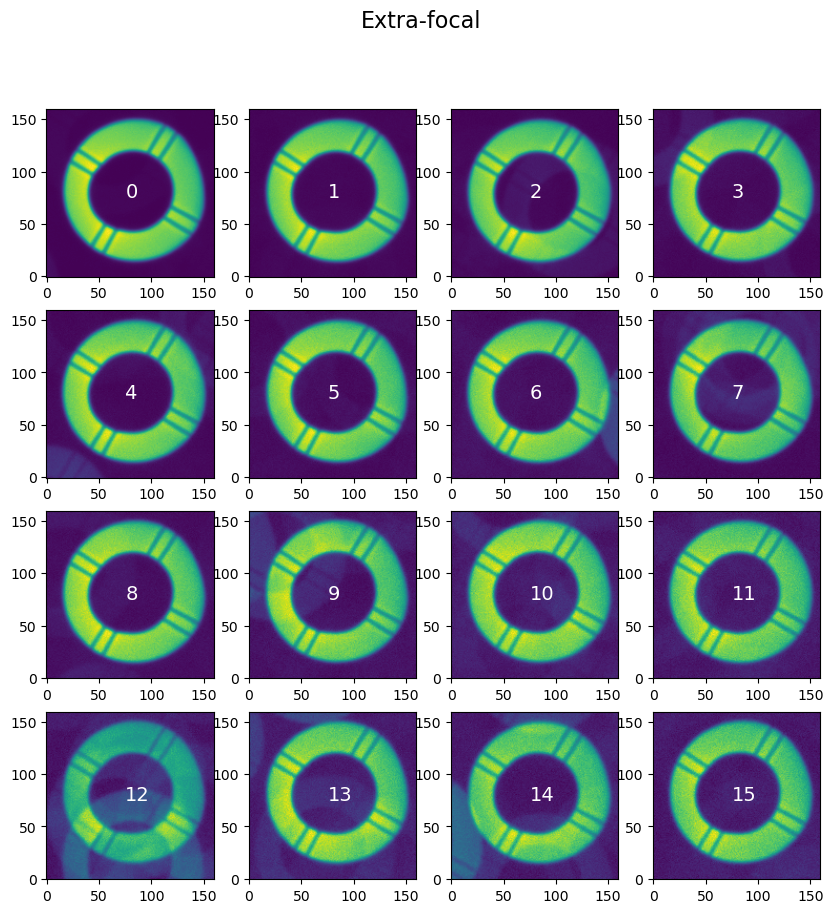

In [61]:
import matplotlib.pyplot as plt 
import numpy as np 

fig,axs = plt.subplots(4,4,figsize=(10,10))
ax = np.ravel(axs)

for i in range(Nstamps):
    ax[i].imshow(cutoutResults.donutStampsExtra[i].stamp_im.image.array, origin='lower')
    ax[i].text(75,75,i, fontsize=14, color='white')
fig.suptitle('Extra-focal', fontsize=16)

Note: needed to increase `maxRecenterDistance` to 30, as the default 20 resulted in all intra-focal donuts being not centered.

Text(0.5, 0.98, 'Intra-focal')

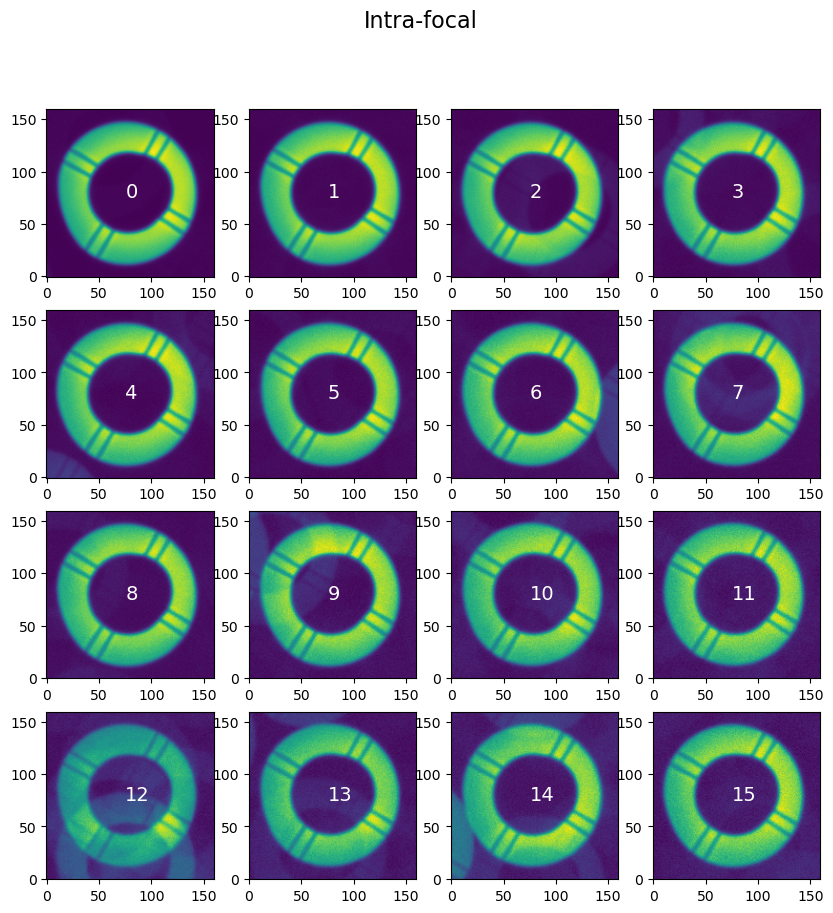

In [62]:
import matplotlib.pyplot as plt 
import numpy as np 

fig,axs = plt.subplots(4,4,figsize=(10,10))
ax = np.ravel(axs)

for i in range(Nstamps):
    ax[i].imshow(cutoutResults.donutStampsIntra[i].stamp_im.image.array, origin='lower')
    ax[i].text(75,75,i, fontsize=14, color='white')
fig.suptitle('Intra-focal', fontsize=16)

Ok, so perhaps we'd rather have donut #12 not included. Let's see which ones would not get selected if we turn on selection:

In [59]:
config = CalcZernikesTaskConfig()
config.donutStampSelector.selectWithEntropy = True
config.donutStampSelector.selectWithSignalToNoise = True
calcTask = CalcZernikesTask(config=config, name="Selection with default params")


In [60]:
taskOut2 = calcTask.run(cutoutResults.donutStampsExtra, cutoutResults.donutStampsIntra)

INFO:lsst.Selection with default params.donutStampSelector:Selected 11/16 donut stamps
INFO:lsst.Selection with default params.donutStampSelector:Selected 12/16 donut stamps
INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 10 pairs out of 11 in final Zernike estimate.


Show which ones did not get selected with red: 

In [64]:
taskOut2.donutsExtraQuality

,SN,ENTROPY,SN_SELECT,ENTROPY_SELECT,FINAL_SELECT
0,2376.776143,1.747002,True,True,True
1,2831.214807,1.705746,True,True,True
2,2402.651121,2.953187,True,True,True
3,2100.499076,2.623457,True,True,True
4,1820.674003,2.678547,True,True,True
5,2079.789784,2.558458,True,True,True
6,1533.933824,2.630614,True,True,True
7,1515.656831,3.568377,True,False,False
8,2770.170436,2.896861,True,True,True
9,1401.096022,3.515167,True,False,False


In [66]:
taskOut2.donutsExtraQuality['SN_SELECT'][12]

False

Text(0.5, 0.98, 'Extra-focal')

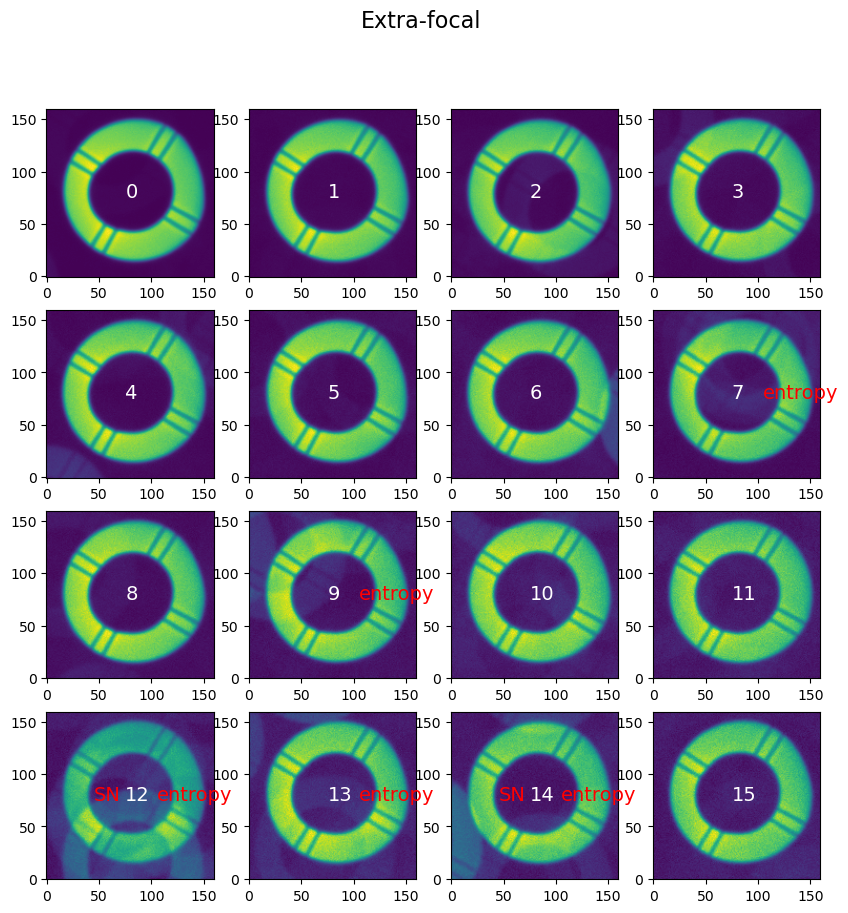

In [70]:
import matplotlib.pyplot as plt 
import numpy as np 

fig,axs = plt.subplots(4,4,figsize=(10,10))
ax = np.ravel(axs)

for i in range(Nstamps):
    ax[i].imshow(cutoutResults.donutStampsExtra[i].stamp_im.image.array, origin='lower')
    ax[i].text(75,75,i, fontsize=14, color='white')
    if not taskOut2.donutsExtraQuality['SN_SELECT'][i]:
        ax[i].text(45,75,'SN', fontsize=14, color='red')
    if not taskOut2.donutsExtraQuality['ENTROPY_SELECT'][i]:
        ax[i].text(105,75,'entropy', fontsize=14, color='red')
    
fig.suptitle('Extra-focal', fontsize=16)

Text(0.5, 0.98, 'Intra-focal')

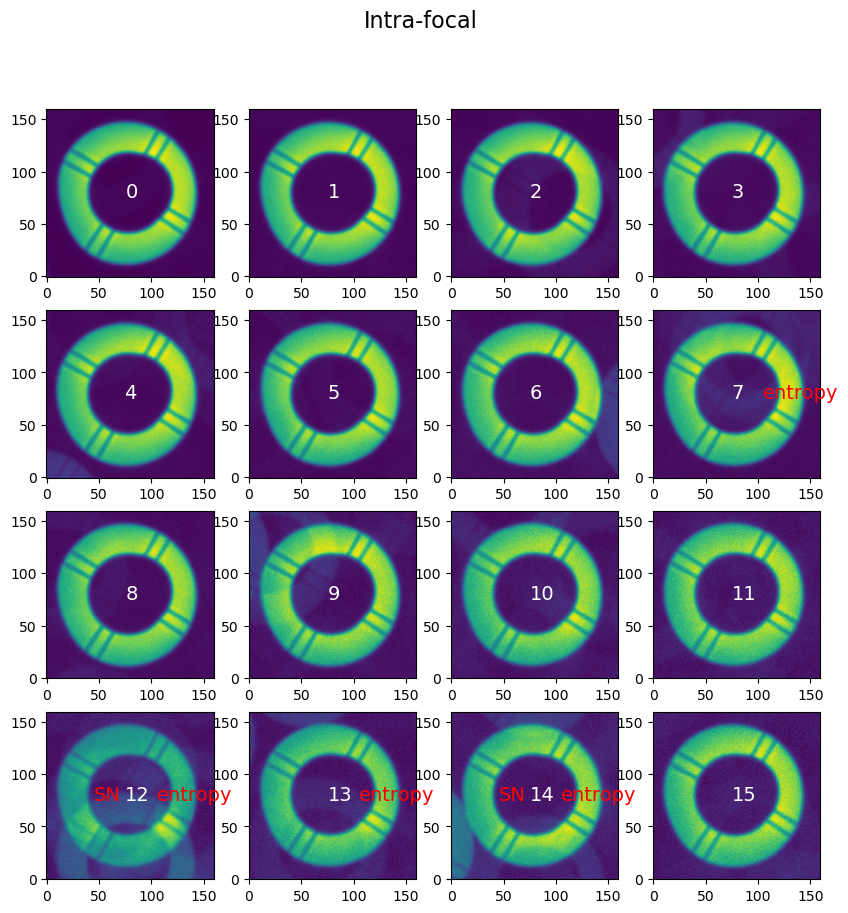

In [71]:
import matplotlib.pyplot as plt 
import numpy as np 

fig,axs = plt.subplots(4,4,figsize=(10,10))
ax = np.ravel(axs)

for i in range(Nstamps):
    ax[i].imshow(cutoutResults.donutStampsIntra[i].stamp_im.image.array, origin='lower')
    ax[i].text(75,75,i, fontsize=14, color='white')
    if not taskOut2.donutsIntraQuality['SN_SELECT'][i]:
        ax[i].text(45,75,'SN', fontsize=14, color='red')
    if not taskOut2.donutsIntraQuality['ENTROPY_SELECT'][i]:
        ax[i].text(105,75,'entropy', fontsize=14, color='red')
    
fig.suptitle('Intra-focal', fontsize=16)

Pipeline config to run the same as a pipetask:



    #!/bin/bash -l 
    
    REPO=/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/gen3repo
    INPUT_COLLECTION=run_739388,LSSTCam/calib/unbounded
    OUTPUT_COLLECTION=test_SN_no_var_det34_sel
    PIPELINE_FILE=/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/lsstCam_det34_no_var_pipeline.yaml
        
      cat <<EOF > $PIPELINE_FILE
      description: Stars pipeline
      instrument: lsst.obs.lsst.LsstCam
      tasks:
        generateDonutDirectDetectTask: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        cutOutDonutsScienceSensorTask: 
                class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
                config:
                   maxRecenterDistance: 35
        calcZernikesTask:
                class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
                config:
                   donutStampSelector.selectWithEntropy: True
                   donutStampSelector.selectWithSignalToNoise: True
    EOF
        
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE --instrument lsst.obs.lsst.LsstCam  -d "exposure.day_obs=20280818 and visit.seq_num in (960,962) and detector = 34" --register-dataset-types


This was saved as  `/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/testSN_lsstCam_det34_noVar_SN.sh`, and was executed with:


    setup lsst_sitcom
    aos
    source testSN_lsstCam_det34_noVar_SN.sh 




NB: I  kept getting this error

    FileNotFoundError: Not enough datasets (0) found for non-optional connection generateDonutDirectDetectTask.camera (camera) with minimum=1 for quantum data ID {instrument: 'LSSTCam', detector: 34, visit: 5028081800962, band: 'z', physical_filter: 'z_20'}.
                                                                                                                                  not because the data query was incorrect, but because `LSSTCam/calib/unbounded` collection  which contains the `camera`    was missing from the input collections.      
                                                                                                                                       

In [96]:
#registry.queryDatasets?

In [91]:
dataRefs =  registry.queryDataIds(datasets='postISRCCD', collections=['run_739388'], 
                                  dimensions=['detector','exposure', 'instrument'],
                                 ).expanded()

In [94]:
dataRefs = registry.queryDatasets(datasetType='postISRCCD', collections=['run_739388'], 
                                  dimensions=['detector','exposure', 'instrument'],
                                  where=f"instrument='LSSTCam' and detector=34")

In [95]:
for ref in dataRefs:
    print(ref)

postISRCCD@{instrument: 'LSSTCam', detector: 34, exposure: 5028081800960, band: 'z', physical_filter: 'z_20'} [sc=Exposure] (run=run_739388 id=1ece0573-0ba9-4d29-82a0-8bfb103da95b)
postISRCCD@{instrument: 'LSSTCam', detector: 34, exposure: 5028081800961, band: 'z', physical_filter: 'z_20'} [sc=Exposure] (run=run_739388 id=617a200e-9df3-4dbb-8ccf-1d05f6351423)
postISRCCD@{instrument: 'LSSTCam', detector: 34, exposure: 5028081800962, band: 'z', physical_filter: 'z_20'} [sc=Exposure] (run=run_739388 id=1fe0d8af-0e1a-4ab6-8ff9-7512c6279210)


Well, they're right there! Ok, there was nothing wrong with the expression. The issue was that the `camera` actually exists in a different repo, which needs to be included in the input:

`LSSTCam/calib/unbounded`


Show that the outputs are there:

In [111]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry

In [112]:
registry.queryCollections()

['refcats/gaia_dr2_20200414',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTCam/calib/curated/19700101T000000Z',
 'LSSTCam/raw/all',
 'run1',
 'runFAM_test',
 'runFAM',
 'runFAM1',
 'runFAM_det160-161',
 'runFAM_det160-161_1',
 'runFAM_det160-161_2',
 'runFAM_det160-161_3',
 'runFAM_det160-161_4',
 'runFAM_det160-161_37',
 'runFAM_det160-161_46',
 'runFAM_det160-161_36',
 'runFAM_det160-161_30',
 'runFAM_det160-161_2023_47_ext',
 'runFAM_det160-161_2023_47_ext_1',
 'runFAM_det93-94_2023_47_ext_1',
 'runFAM_det93-94_2023_47_ext_lim_13-17',
 'runFAM_940-942',
 'run_739789',
 'run_739388',
 'runFAM_960_962_det93-94_2023_47_ext_lim_11-15',
 'aaa_bps_test2/20240110T004504Z',
 'runFAM_960_962_all_det_2023_47_ext_lim_11-15_bps/20240110T060752Z',
 'runFAM_960_962_all_det_2023_47_ext_lim_11-15_bps_science/20240110T062107Z',
 'runFAM_960_962_all_det_2024_02_ext_lim_12-15_bps_science/20240124T223708Z',
 'runFAM_961_all_det_2024_02_ext_lim_12-15_bps_wavefront/20240124T224434Z',
 'runFAM_961_

So the new collection is there - `test_SN_no_var_det34_sel`  .   We also have the new data type: 

In [113]:
registry.queryDatasetTypes()

[DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog),
 DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True),
 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('packages', {}, Packages),
 DatasetType('isr_config', {}, Config),
 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, TaskMetadata),
 DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords),
 DatasetType('cutOutDonutsScienceSensorTask_config', {}, Config),
 DatasetType('calcZernikesTask_config', {}, Config),
 DatasetType('generateDonutCatalogWcsTask_config', {}, Config),
 DatasetType('donutCatalog', {band, instrument, detector, physical_filter, visit}, DataFrame),
 DatasetType('donutStampsIntra', {

Both `donutsExtraQuality` and `donutsIntraQuality` are there too. 

In [114]:
dataRefs = registry.queryDatasets('donutsExtraQuality', collections=['test_SN_no_var_det34_sel'])

In [115]:
for ref in dataRefs:
    print(ref)

donutsExtraQuality@{instrument: 'LSSTCam', detector: 34, visit: 5028081800962, band: 'z', physical_filter: 'z_20'} [sc=DataFrame] (run=test_SN_no_var_det34_sel/20240813T235233Z id=b653822f-e1f2-4679-b0b9-b4fc98fab99f)


In [117]:
donutsExtraQuality  = butler.get('donutsExtraQuality', 
                                 collections=['test_SN_no_var_det34_sel'],
                                 dataId = ref.dataId)

In [118]:
donutsExtraQuality

,SN,ENTROPY,SN_SELECT,ENTROPY_SELECT,FINAL_SELECT
0,2376.427344,1.747111,True,True,True
1,2831.327651,1.705242,True,True,True
2,2402.401395,2.952322,True,True,True
3,2100.892340,2.623945,True,True,True
4,1820.542401,2.677880,True,True,True
5,2079.316833,2.557791,True,True,True
6,1534.025253,2.630312,True,True,True
7,1515.793599,3.567497,True,False,False
8,2770.022126,2.897050,True,True,True
9,1400.924809,3.514363,True,False,False


So indeed some donuts didn't get selected. Show the Zernike output:

In [119]:
zkEstimate = butler.get('zernikeEstimateRaw', collections=['test_SN_no_var_det34_sel'],
                        dataId = ref.dataId
                       )

In [120]:
len(zkEstimate)

11

Which reflects the fact that we did not calculate Zernike estimate for donut stamps that did not get selected. 

# 1 b) lsstCam sweep data:  run from ISR with variance to show behavior for current data (with variance)

In [7]:
postIsrCollection ='run_739388'